select (resn ARG and (name NH1 or name NH2)) or (resn LYS and name NZ) or (resn HIS and name NE2)

distance ((resn ASP and name OD2) or (resn GLU and name OD2)),((resn ARG and (name NH1 or name NH2)) or (resn LYS and name NZ) or (resn HIS and name NE2)),4

In [1]:
from pymol import cmd
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from pymol import cmd, CmdException


def get_raw_distances(names='', state=1, selection='all', quiet=1):
    '''
DESCRIPTION

    Get the list of pair items from distance objects. Each list item is a
    tuple of (index1, index2, distance).

    Based on a script from Takanori Nakane, posted on pymol-users mailing list.
    http://www.mail-archive.com/pymol-users@lists.sourceforge.net/msg10143.html

ARGUMENTS

    names = string: names of distance objects (no wildcards!) {default: all
    measurement objects}

    state = integer: object state {default: 1}

    selection = string: atom selection {default: all}

SEE ALSO

    select_distances, cmd.find_pairs, cmd.get_raw_alignment
    '''
    from chempy import cpv

    state, quiet = int(state), int(quiet)
    if state < 1:
        state = cmd.get_state()

    valid_names = cmd.get_names_of_type('object:measurement')
    if names == '':
        names = ' '.join(valid_names)
    else:
        for name in names.split():
            if name not in valid_names:
                print(' Error: no such distance object: ' + name)
                raise CmdException

    raw_objects = cmd.get_session(names, 1, 1, 0, 0)['names']

    xyz2idx = {}
    cmd.iterate_state(state, selection, 'xyz2idx[x,y,z] = (model,index)',
                      space=locals())

    r = []
    for obj in raw_objects:
        try:
            points = obj[5][2][state - 1][1]
            if points is None:
                raise ValueError
        except (KeyError, ValueError, IndexError):
            continue
        for i in range(0, len(points), 6):
            xyz1 = tuple(points[i:i + 3])
            xyz2 = tuple(points[i + 3:i + 6])
            try:
                r.append((xyz2idx[xyz1], xyz2idx[xyz2], cpv.distance(xyz1, xyz2)))
                if not quiet:
                    print(' get_raw_distances: ' + str(r[-1]))
            except KeyError:
                if quiet < 0:
                    print(' Debug: no index for %s %s' % (xyz1, xyz2))
    return r

In [2]:
avaiable_DF = pd.read_csv("available_result.csv")

In [3]:
saltbridge_A501_list = []
saltbridge_3DAC_list = []
for i in range(avaiable_DF.shape[0]):
    cmd.load("A501/A501_summary/%s/relaxed_model_1.pdb"%avaiable_DF["A501_sequence_id"][i],"%s_1"%avaiable_DF["A501_sequence_id"][i])
    cmd.distance("saltbridge","(resn ASP and name OD2) or (resn GLU and name OD2)","(resn ARG and (name NH1 or name NH2)) or (resn LYS and name NZ) or (resn HIS and name NE2)",cutoff=4)
    saltbridge_A501_list.append(len(get_raw_distances("saltbridge")))
    cmd.reinitialize()

    cmd.load("3DAC/3DAC_summary/%s/relaxed_model_2.pdb"%avaiable_DF["3DAC_sequence_id"][i],"%s_1"%avaiable_DF["3DAC_sequence_id"][i])
    cmd.distance("saltbridge","(resn ASP and name OD2) or (resn GLU and name OD2)","(resn ARG and (name NH1 or name NH2)) or (resn LYS and name NZ) or (resn HIS and name NE2)",cutoff=4)
    saltbridge_3DAC_list.append(len(get_raw_distances("saltbridge")))
    cmd.reinitialize()

    print(i,end=",")

 PyMOL not running, entering library mode (experimental)
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,2

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


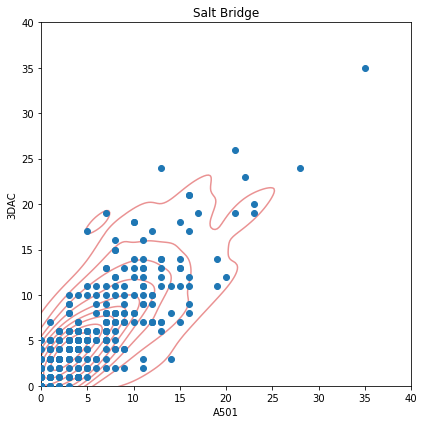

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(saltbridge_A501_list,saltbridge_3DAC_list,zorder=3,color="tab:blue")
sns.kdeplot(saltbridge_A501_list,saltbridge_3DAC_list,shade=False,color="tab:red",alpha=0.5)
plt.xlim(0,40)
plt.ylim(0,40)
plt.xlabel("A501")
plt.ylabel("3DAC")
plt.title("Salt Bridge")

plt.tight_layout()
plt.savefig("Figure/saltbridge1.png",dpi=200)

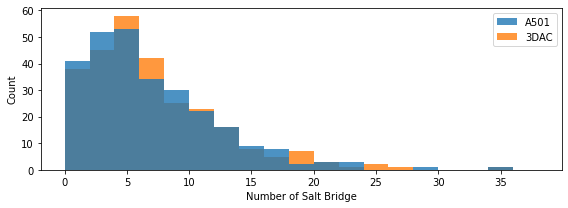

In [5]:
plt.figure(figsize=(8,3))

plt.hist(saltbridge_A501_list,bins=np.arange(0,40,2),zorder=5,alpha=0.8,label="A501")
plt.hist(saltbridge_3DAC_list,bins=np.arange(0,40,2),zorder=3,alpha=0.8,label="3DAC")
plt.legend()
plt.xlabel("Number of Salt Bridge")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("Figure/saltbridge2.png",dpi=200)


In [6]:
avaiable_DF["A501_salt_bridge"] = saltbridge_A501_list
avaiable_DF["3DAC_salt_bridge"] = saltbridge_3DAC_list
avaiable_DF.to_csv("available_result.csv",index=False)

In [7]:
avaiable_DF

,A501_sequence_id,A501_sequence_name,A501_sequence,A501_structure_status,3DAC_sequence_name,3DAC_sequence_id,3DAC_sequence,A501_structure_model_1_score,A501_structure_model_2_score,3DAC_structure_status,...,salt_bridge_diff,hydrogen_bond_diff,disulfide_bond_diff,A501_secondary_structure_H_Part,A501_secondary_structure_S_Part,A501_secondary_structure_L_Part,3DAC_secondary_structure_H_Part,3DAC_secondary_structure_S_Part,3DAC_secondary_structure_L_Part,Function_tag
0,A501_001,WP_011250482.1,MAKKGAGATRGISPVRPTRALPIGAYLKVADNSGAKVIQIIGVVGY...,True,Chromosome1_1050,3DAC_210,MVRPYSRLKIADNSGVKEIQVIRVIGNLQDDALNPNVKIWGTVGDI...,90.681015,90.474789,True,...,-2,0,0,0.106383,0.347518,0.546099,0.092308,0.392308,0.515385,Biological process
1,A501_002,WP_042692804.1,MGKSLIQQRRGKGTTTFRAPSHRYRGAVKYVPLNVVKEKTLRGVVE...,True,Chromosome1_1057,3DAC_211,MGIKKFKPTTPGRRHMTVLDFSEITKTEPEKSLVVTKKSTGGRNNQ...,94.120890,93.913161,True,...,-4,-34,0,0.142259,0.255230,0.602510,0.089606,0.225806,0.684588,Biological process
2,A501_003,WP_042693005.1,MKVVRFGVSVPEELLEKFDRIIEEKGYVNRSEAIRDLMRDFIIRHE...,True,Chromosome1_210,3DAC_024,MRFTVSVDDEIGAFIDSLVKEYGYASRSELIRDLAREKKAELEVGD...,95.654313,95.708373,True,...,3,6,0,0.420290,0.282609,0.297101,0.461538,0.292308,0.246154,Biological process
3,A501_004,WP_050001839.1,MDCTKDYCVKDLSLATSGEKKIDWVSRFMPVLQTIRREFEREKPFK...,True,Chromosome1_1121,3DAC_224,MAHVKDISLAPHGWKKINWVKAHMKVMPLVKKRLDEKGIFKGVRIG...,96.819289,96.925328,True,...,8,27,1,0.508314,0.168646,0.323040,0.516990,0.150485,0.332524,Biosynthesis and metabolism
4,A501_005,WP_050001842.1,MRRDYTLYLFASLGSFLIAYIALPLVIIFAKQLMDWEMLVKTLHDP...,True,Chromosome1_359,3DAC_056,MLRFFATLLAFIILLPFLGLSIYTTPSELWHALTNPDVLDALKNSF...,95.500631,95.463742,True,...,1,9,0,0.878543,0.000000,0.121457,0.848000,0.000000,0.152000,Transporter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,A501_299,WP_050003989.1,MELLKLNVVPCRFIERLNRFVALVEVGGDVRKALVTNTGRLEEFMI...,True,Chromosome1_1280,3DAC_263,MIKLNADIGKNHTQGTFIKRINRFVAEVEVNGKRYHAHLHDSGRLG...,96.534032,96.902222,True,...,0,31,0,0.205882,0.474790,0.319328,0.200000,0.443478,0.356522,Function unknown
271,A501_300,WP_081947179.1,MQVYEGKAKKVIPLDDGKAIMEFKDDATAFNGEKKAQFRGKGWLNA...,True,Chromosome1_715,3DAC_131,MVYEGKTKIVEIKDGYAYLHFKDDITAGDGEKHDVMSGKGSMCAEI...,96.261229,96.562634,True,...,-1,6,0,0.331915,0.289362,0.378723,0.339130,0.295652,0.365217,Biosynthesis and metabolism
272,A501_301,WP_081947215.1,MLYPALAVVDPGLPRRTPELIDWESLSVITALIMASKGLELSGIFS...,True,Chromosome1_85,3DAC_013,MVKIKNWFKNNWLLVVSVTVAIVLYAFDRGPLHRYIGYHDAKVLLV...,92.334227,92.401615,True,...,-1,-35,0,0.821637,0.000000,0.178363,0.831025,0.000000,0.168975,Biosynthesis and metabolism
273,A501_302,WP_081947255.1,MGQQAGLREDKTRREGRGVAVRLRTPLSTEDVLRLEVGDVVYLSGE...,True,Chromosome1_624,3DAC_108,MFDAQAGSRMLYTGYLYTMRDGTLKRLINDSFQFTDIFPVYFCGPS...,90.763258,89.957586,True,...,3,42,0,0.253968,0.306878,0.439153,0.269737,0.309211,0.421053,Energy production and coversion


In [8]:
sum(abs(avaiable_DF["A501_salt_bridge"] - avaiable_DF["3DAC_salt_bridge"])>=10)

4

In [9]:
avaiable_DF["salt_bridge_diff"] = avaiable_DF["A501_salt_bridge"] - avaiable_DF["3DAC_salt_bridge"]
avaiable_DF["hydrogen_bond_diff"] = avaiable_DF["A501_hydrogen_bond"] - avaiable_DF["3DAC_hydrogen_bond"]
avaiable_DF["disulfide_bond_diff"] = avaiable_DF["A501_disulfide_bond"] - avaiable_DF["3DAC_disulfide_bond"]

In [10]:
avaiable_DF.to_csv("available_result.csv",index=False)

Text(0, 0.5, 'Hydrogen bond diff')

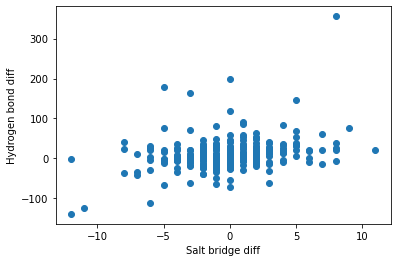

In [11]:
plt.scatter(avaiable_DF["salt_bridge_diff"],avaiable_DF["hydrogen_bond_diff"])
plt.xlabel("Salt bridge diff")
plt.ylabel("Hydrogen bond diff")

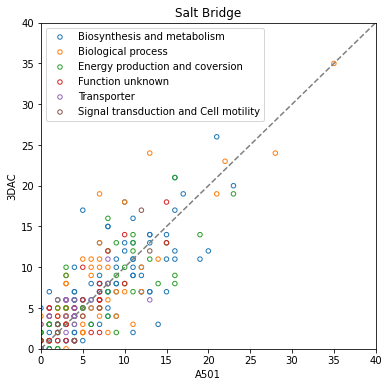

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(avaiable_DF[avaiable_DF["Function_tag"]=="Biosynthesis and metabolism"]["A501_salt_bridge"],
            avaiable_DF[avaiable_DF["Function_tag"]=="Biosynthesis and metabolism"]["3DAC_salt_bridge"],
            label="Biosynthesis and metabolism",
            edgecolors="tab:blue",
            color="None",
            s=20)

plt.scatter(avaiable_DF[avaiable_DF["Function_tag"]=="Biological process"]["A501_salt_bridge"],
            avaiable_DF[avaiable_DF["Function_tag"]=="Biological process"]["3DAC_salt_bridge"],
            label="Biological process",
            edgecolors="tab:orange",
            color="None",
            s=20)

plt.scatter(avaiable_DF[avaiable_DF["Function_tag"]=="Energy production and coversion"]["A501_salt_bridge"],
            avaiable_DF[avaiable_DF["Function_tag"]=="Energy production and coversion"]["3DAC_salt_bridge"],
            label="Energy production and coversion",
            edgecolors="tab:green",
            color="None",
            s=20)

plt.scatter(avaiable_DF[avaiable_DF["Function_tag"]=="Function unknown"]["A501_salt_bridge"],
            avaiable_DF[avaiable_DF["Function_tag"]=="Function unknown"]["3DAC_salt_bridge"],
            label="Function unknown",
            edgecolors="tab:red",
            color="None",
            s=20)

plt.scatter(avaiable_DF[avaiable_DF["Function_tag"]=="Transporter"]["A501_salt_bridge"],
            avaiable_DF[avaiable_DF["Function_tag"]=="Transporter"]["3DAC_salt_bridge"],
            label="Transporter",
            edgecolors="tab:purple",
            color="None",
            s=20)

plt.scatter(avaiable_DF[avaiable_DF["Function_tag"]=="Signal transduction and Cell motility"]["A501_salt_bridge"],
            avaiable_DF[avaiable_DF["Function_tag"]=="Signal transduction and Cell motility"]["3DAC_salt_bridge"],
            label="Signal transduction and Cell motility",
            edgecolors="tab:brown",
            color="None",
            s=20)

plt.plot([0,40],[0,40],linestyle="--",color="tab:gray")
plt.xlim(0,40)
plt.ylim(0,40)
plt.legend()
plt.xlabel("A501")
plt.ylabel("3DAC")
plt.title("Salt Bridge")
plt.savefig("Figure/Salt_Bridge.png",dpi=300)

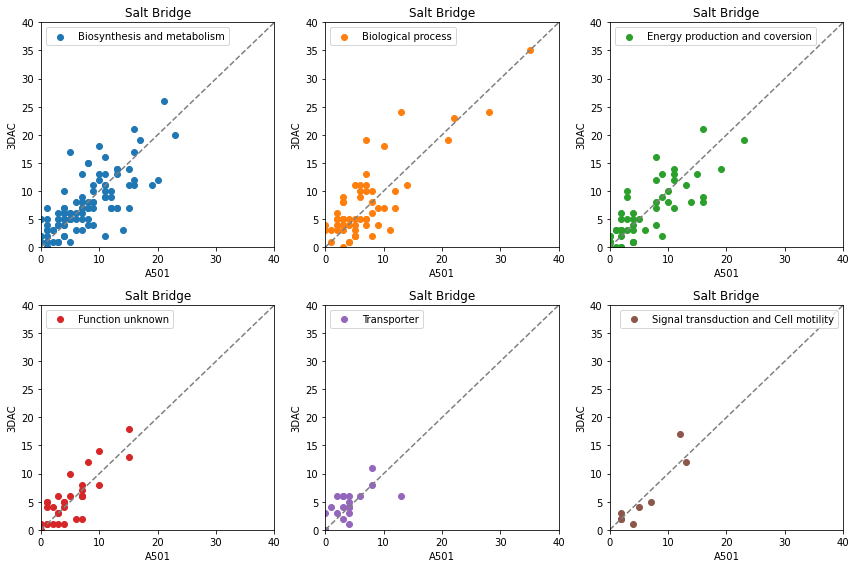

In [13]:
plt.figure(figsize=(12,8))

plt.subplot(231)
plt.scatter(avaiable_DF[avaiable_DF["Function_tag"]=="Biosynthesis and metabolism"]["A501_salt_bridge"],
            avaiable_DF[avaiable_DF["Function_tag"]=="Biosynthesis and metabolism"]["3DAC_salt_bridge"],
            label="Biosynthesis and metabolism",
            color="tab:blue")
plt.plot([0,40],[0,40],linestyle="--",color="tab:gray")
plt.xlim(0,40)
plt.ylim(0,40)
plt.legend()
plt.xlabel("A501")
plt.ylabel("3DAC")
plt.title("Salt Bridge")


plt.subplot(232)
plt.scatter(avaiable_DF[avaiable_DF["Function_tag"]=="Biological process"]["A501_salt_bridge"],
            avaiable_DF[avaiable_DF["Function_tag"]=="Biological process"]["3DAC_salt_bridge"],
            label="Biological process",
            color="tab:orange")
plt.plot([0,40],[0,40],linestyle="--",color="tab:gray")
plt.xlim(0,40)
plt.ylim(0,40)
plt.legend()
plt.xlabel("A501")
plt.ylabel("3DAC")
plt.title("Salt Bridge")


plt.subplot(233)
plt.scatter(avaiable_DF[avaiable_DF["Function_tag"]=="Energy production and coversion"]["A501_salt_bridge"],
            avaiable_DF[avaiable_DF["Function_tag"]=="Energy production and coversion"]["3DAC_salt_bridge"],
            label="Energy production and coversion",
            color="tab:green")
plt.plot([0,40],[0,40],linestyle="--",color="tab:gray")
plt.xlim(0,40)
plt.ylim(0,40)
plt.legend()
plt.xlabel("A501")
plt.ylabel("3DAC")
plt.title("Salt Bridge")


plt.subplot(234)
plt.scatter(avaiable_DF[avaiable_DF["Function_tag"]=="Function unknown"]["A501_salt_bridge"],
            avaiable_DF[avaiable_DF["Function_tag"]=="Function unknown"]["3DAC_salt_bridge"],
            label="Function unknown",
            color="tab:red")
plt.plot([0,40],[0,40],linestyle="--",color="tab:gray")
plt.xlim(0,40)
plt.ylim(0,40)
plt.legend()
plt.xlabel("A501")
plt.ylabel("3DAC")
plt.title("Salt Bridge")


plt.subplot(235)
plt.scatter(avaiable_DF[avaiable_DF["Function_tag"]=="Transporter"]["A501_salt_bridge"],
            avaiable_DF[avaiable_DF["Function_tag"]=="Transporter"]["3DAC_salt_bridge"],
            label="Transporter",
            color="tab:purple")
plt.plot([0,40],[0,40],linestyle="--",color="tab:gray")
plt.xlim(0,40)
plt.ylim(0,40)
plt.legend()
plt.xlabel("A501")
plt.ylabel("3DAC")
plt.title("Salt Bridge")


plt.subplot(236)
plt.scatter(avaiable_DF[avaiable_DF["Function_tag"]=="Signal transduction and Cell motility"]["A501_salt_bridge"],
            avaiable_DF[avaiable_DF["Function_tag"]=="Signal transduction and Cell motility"]["3DAC_salt_bridge"],
            label="Signal transduction and Cell motility",
            color="tab:brown")
plt.plot([0,40],[0,40],linestyle="--",color="tab:gray")
plt.xlim(0,40)
plt.ylim(0,40)
plt.legend()
plt.xlabel("A501")
plt.ylabel("3DAC")
plt.title("Salt Bridge")

plt.tight_layout()
plt.savefig("Figure/SaltBridge_full.png",dpi=300)